# Color segments

A notebook for testing how we can extract color segments arbitrary images. First let's download and read an image.

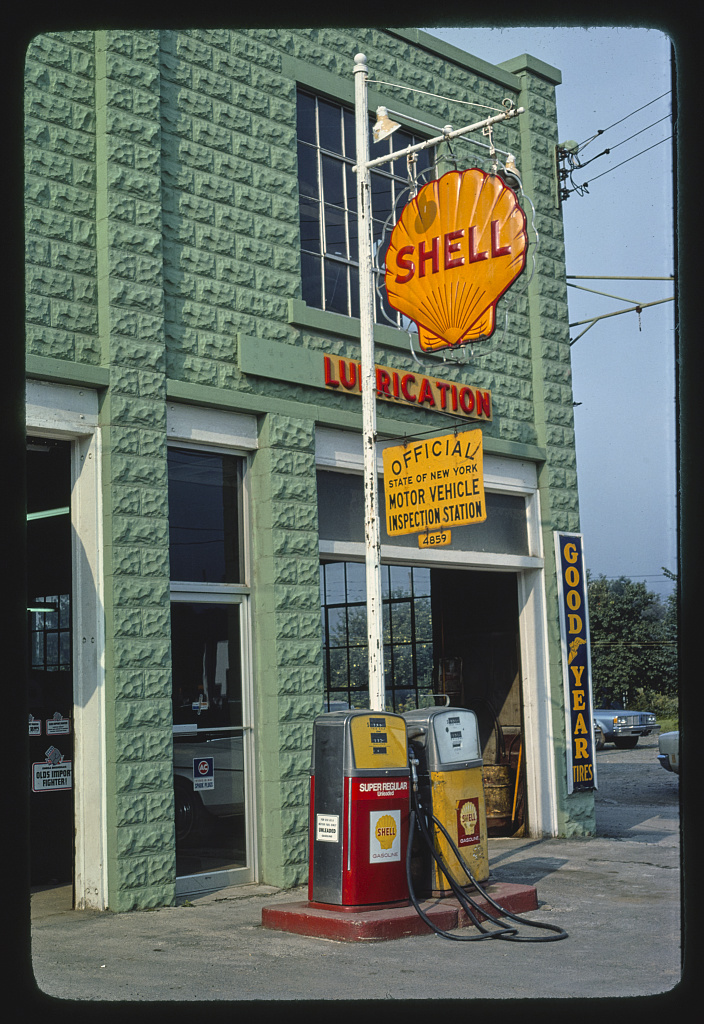

In [1]:
from IPython.display import display
from color_helpers import *

# Source: https://www.loc.gov/resource/mrg.01647/
image_url = "https://tile.loc.gov/storage-services/service/pnp/mrg/01600/01647v.jpg"
im = get_image_from_url(image_url)
display(im)

Now let's get the most dominant colors (adapted from [this notebook](https://github.com/LibraryOfCongress/data-exploration/blob/master/loc.gov%20JSON%20API/Dominant%20colors.ipynb))

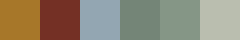

In [2]:
n = 6
order_by = 'saturation'
brightness_range = (0.25, 0.8)
saturation_range = (0.5, 1.0)
colors = get_dominant_colors(im, n, order_by, brightness_range, saturation_range)
palette = draw_colors(colors)
display(palette)

Next, select the first color and find the largest connected sectionS of the image with that color, and highlight the centroids.

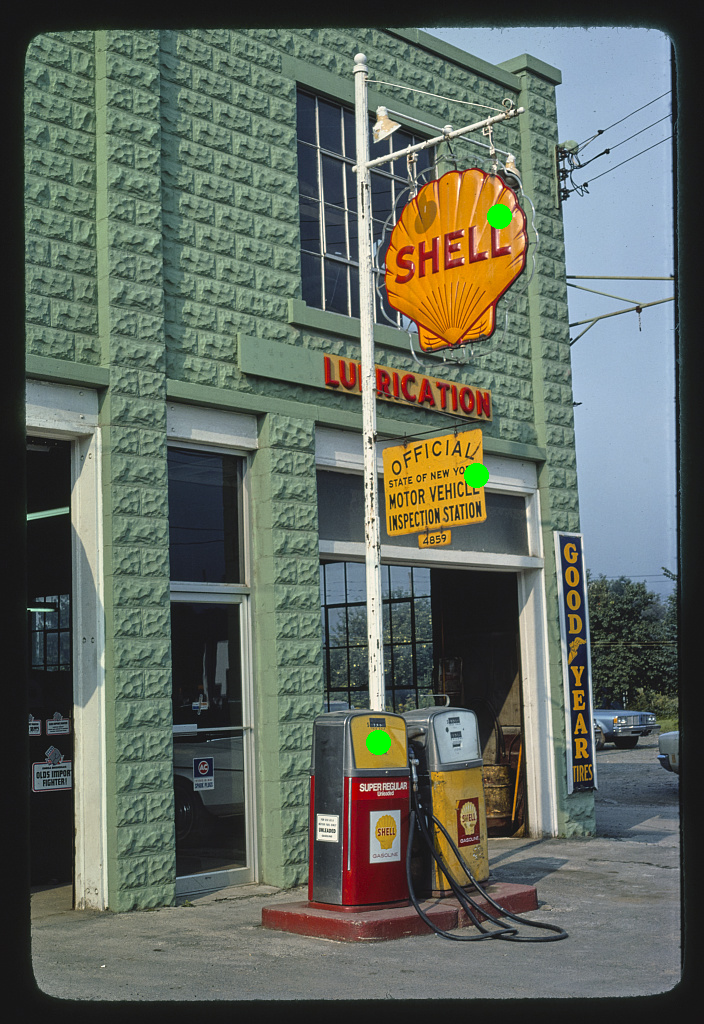

In [3]:
from PIL import ImageDraw
first_color = colors[0]
segments = get_segments_from_color(im, first_color)
image_with_centroids = im.copy()
draw = ImageDraw.Draw(image_with_centroids)
for segment in segments:
    draw.circle(segment["centroid"], radius=12, fill="#00FF00")
display(image_with_centroids)

Next, let's download the Efficient SAM model, unzip, and build it.

In [4]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vits
import os
import zipfile
from segment_helpers import *

destination = "weights/efficient_sam_vits.pt.zip"
if not os.path.isfile("weights/efficient_sam_vits.pt"):
    weight_url = "https://github.com/yformer/EfficientSAM/raw/refs/heads/main/weights/efficient_sam_vits.pt.zip"
    download_file(weight_url, destination)
    with zipfile.ZipFile(destination, 'r') as zip_ref:
        zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()
print("Ready to segment.")

Ready to segment.


Next, let's use the points from the previous steps to indicate what we want to segment.

(np.float64(-0.5), np.float64(703.5), np.float64(1023.5), np.float64(-0.5))

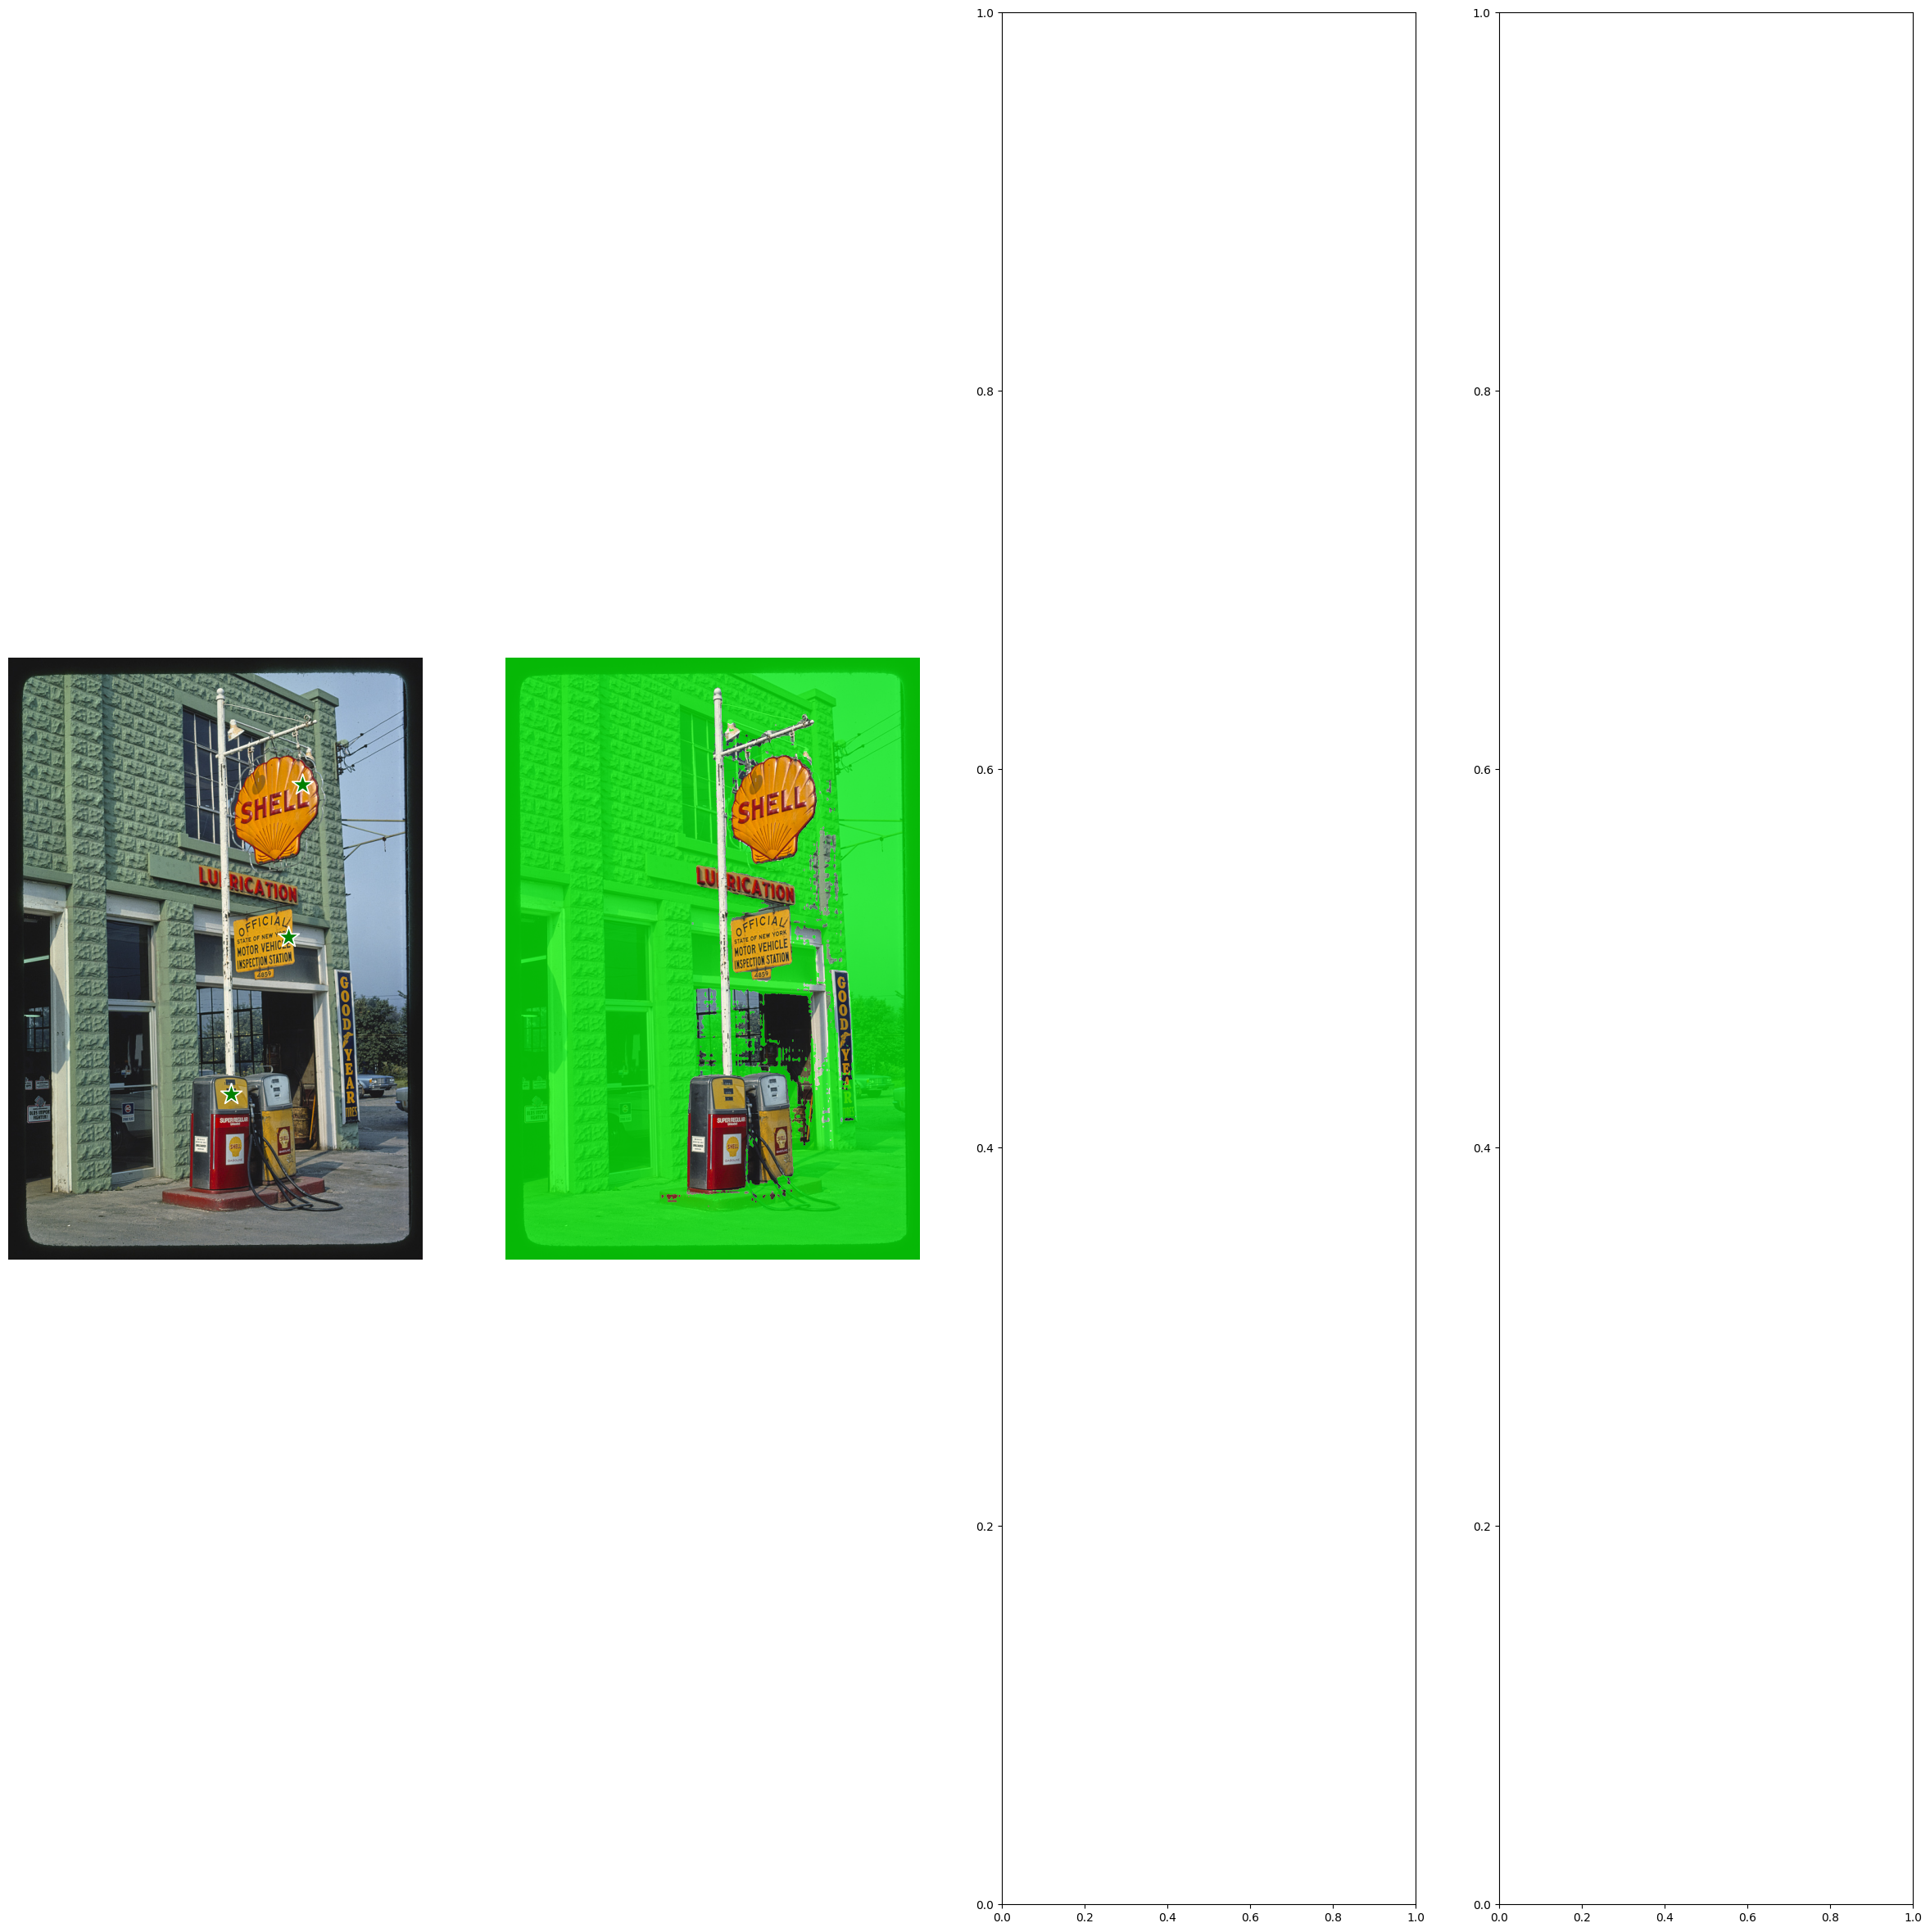

In [ ]:
n_segments = len(segments)
fig, ax = plt.subplots(1, 2, figsize=(100, 100))
show_points(np.array([segment["centroid"] for segment in segments]), ax[0])
ax[0].imshow(im)
ax[0].axis('off')

point = segment["centroid"]
input_label = np.array([1 for i in range(n_segments)])
input_point = np.array([segment["centroid"] for segment in segments])
ax[1].imshow(im)
mask = get_segment_from_point_or_box(im, input_point, input_label, efficient_sam_vits_model)
show_anns(mask, ax[1])
ax[1].axis('off')

# for i, segment in enumerate(segments):
#     point = segment["centroid"]
#     input_label = np.array([1, 1])
#     input_point = np.array([point, point])
#     print(input_point)
#     ax[i + 1].imshow(im)
#     mask = get_segment_from_point_or_box(im, input_point, input_label, efficient_sam_vits_model)
#     show_anns(mask, ax[1 + 1])
#     ax[i + 1].axis('off')